# Introduction

This notebook is about detecting lines of text found on a provided image.

***Please, pay attention that it shows the logic of training the model, but it doesn't include all pieces of code required for runing it from top to bottom and reproduction the result.***

In [ ]:
# ipython widgets' settings

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%matplotlib inline

In [ ]:
# because I use Google Colab, I need to connect it to my Google Drive

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# path to the directory with provided additional materials

repo_folder = '/content/drive/MyDrive/DeepLearning2/'

In [ ]:
# install prerequisites

reqs_path = repo_folder + 'IntelligentDocumentProcessing/requirements.txt'
!pip3 install -r {reqs_path}

In [ ]:
# connect to WandB

import wandb
wandb_key = open('/content/drive/MyDrive/ssh/wandbkey.txt').read()
wandb.login(key=wandb_key.strip())

In [ ]:
# simplify using provided utilities

import sys
base_folder = repo_folder + 'IntelligentDocumentProcessing/Resources/a_Text_Detection/'
sys.path.append(base_folder)

In [ ]:
# use the same random seed for getting a stable result

from utils import set_seed

set_seed(17)

# Data

We are using [HierText](https://github.com/google-research-datasets/hiertext) dataset (by Google Research).

The data have already divided between `train` and `validation` directories. The markup is at files `train.jsonl` and `validation.jsonl`.
Our task on this stage includes reading the data and doing EDA. We also create a class which returns an image and its markup based on provided index of the image. The class calls `HierTextAdapter`, and it has the following interface:

```python
class HierTextAdapter(BaseAdapter):

  def load_anns(self):
    '''
    Upload information from a markup file (JSON).
    '''
    pass
  
  def prepare_ann(ann):
    '''
    Transform one markup element to standardized format in order to put it into a model / loss fnction / metrics.
    '''
    pass
  
  def __getitem__(self, idx) -> Item:
    '''
    Returns all available information about one markup element, such as image name, image itself, markup data about the image.
    '''
    pass
```

## Uploading the data

In [ ]:
%%time

from utils import HierTextAdapter

# HierText
train_hiertext_adapter = HierTextAdapter(
    ann_path='/content/drive/MyDrive/data/hiertext/train.jsonl',
    img_dir='/content/drive/MyDrive/data/hiertext/train',
    unclip_ratio=0,
    fit_min_rot_box=False,
    in_memory=False
)

train_adapters = [
    train_hiertext_adapter,
]
_ = [a[0] for a in train_adapters]

# HierText
val_hiertext_adapter = HierTextAdapter(
    ann_path='/content/drive/MyDrive/data/hiertext/validation.jsonl',
    img_dir='/content/drive/MyDrive/data/hiertext/validation',
    unclip_ratio=0,
    fit_min_rot_box=False,
    in_memory=False
)

val_adapters = [
    val_hiertext_adapter,
]
_ = [a[0] for a in val_adapters]

CPU times: user 36.5 s, sys: 8.43 s, total: 44.9 s
Wall time: 44.4 s


### Visualization

For making EDA, it's important to look at some random examples of data (image and markup simultaneously). The class `DrawMore` was created for this purpose.

Usually `cv2` and `matplotlib` libraries are applied for the visualization.

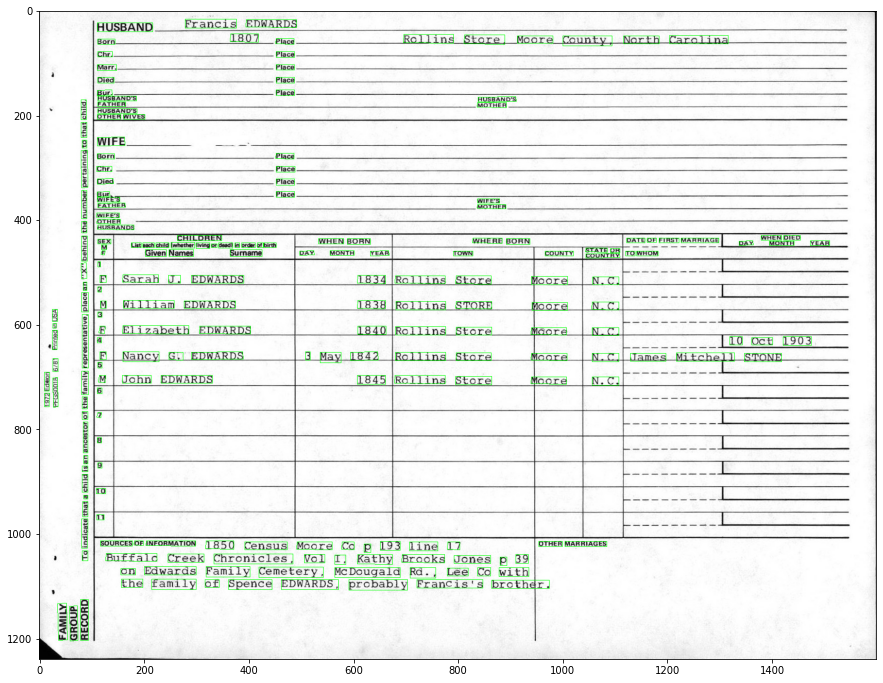

In [ ]:
import matplotlib.pyplot as plt
from utils import DrawMore

item = train_hiertext_adapter[6]

plt.figure(figsize=(15,20))
plt.imshow(DrawMore.draw_contours(item.img, item.word_polygons, thickness=1))
plt.show()

### Calculate statistics

First of all, we need to check that each image in the dataset can be processed. Checking the fact, we can also calculate some useful statistics in parallel. For example, we can calculate the width and height of every bounding box.

In [ ]:
import json

with open(base_folder + 'resources/bboxes_and_shapes_by_image.json', 'r') as r:
    bboxes_and_shapes_by_image = json.load(r)

assert len(bboxes_and_shapes_by_image) == len(val_hiertext_adapter)
print(f'# words on the 1st image: {len(bboxes_and_shapes_by_image[0][0])}')
print(f'1st bounding box on the 1st image: {bboxes_and_shapes_by_image[0][0][0]}')
print(f'Size of the 1st image: {bboxes_and_shapes_by_image[0][1]}')

In [ ]:
import cv2
import numpy as np

widths = [
    cv2.minAreaRect(np.array(bbox))[1][0]
    for one_image_bboxes, _ in bboxes_and_shapes_by_image
    for bbox in one_image_bboxes
]
heights = [
    cv2.minAreaRect(np.array(bbox))[1][1]
    for one_image_bboxes, _ in bboxes_and_shapes_by_image
    for bbox in one_image_bboxes
]

Let's plot distributions of the heights and widths:

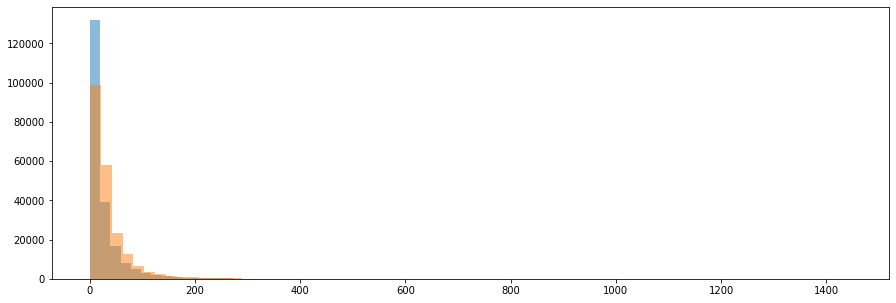

In [ ]:
plt.figure(figsize=(15, 5))
plt.hist(widths, bins=70, alpha=0.5)
plt.hist(heights, bins=70, alpha=0.5)
plt.show()

Then let's make a heatmap of the words' location on images. It helps to find biases when text is distributed in a non-uniform manner. In order to do this we use a mask of size 500x500 pixels, and scale resulting values to range from 0 to 1.

In [ ]:
from typing import List, Tuple
import numpy as np


def scale_coords(shape, size, polygon):
    """Scale the coordinates of a polygon into the image coordinates for a grid cell"""
    w,h = shape
    w_img, h_img = size
    x,y = polygon[:,0], polygon[:,1]

    wp = w_img/w
    xp = np.round(x/wp)
    xp[xp >= w] = w-1

    hp = h_img/h
    yp = np.round(y/hp)
    yp[yp >= h] = h-1

    return np.concatenate([xp[:,None],yp[:,None]], axis=1)


def make_heatmap(
    bboxes_and_shapes_by_image: List[Tuple[List[np.ndarray], List[Tuple]]],
    adapter = HierTextAdapter,
    res_w: int = 500,
    res_h: int = 500
) -> np.ndarray:
    cnt_images = len([bbox
                      for one_image_bboxes, _ in bboxes_and_shapes_by_image
                      for bbox in one_image_bboxes])
    matrix = np.zeros((res_w, res_h))
    for i, (word_polygons, size) in enumerate(bboxes_and_shapes_by_image):
        for bbox in word_polygons:
            adjusted_word_polygons = [
                scale_coords((res_w,res_h), (size[1],size[0]), np.array(bbox)).astype(int)
            ]
            mask = np.zeros((res_w,res_h))
            cv2.fillPoly(mask, adjusted_word_polygons, 1)
            matrix += mask
    return matrix/cnt_images


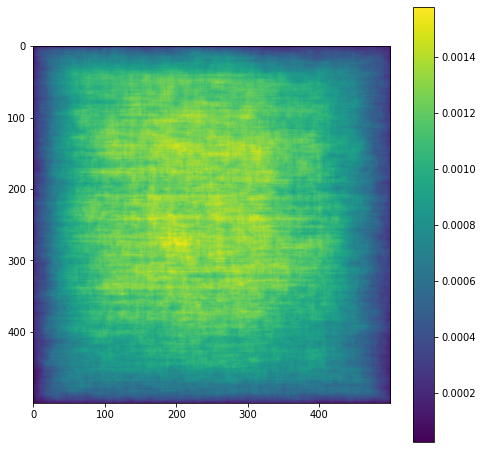

In [ ]:
heatmap = make_heatmap(bboxes_and_shapes_by_image, res_w=500, res_h=500)

plt.figure(figsize=(8, 8))
plt.imshow(heatmap)
plt.colorbar()
plt.show()

The main conclusion is that we have rather small bounding boxes which are located closer to the center. Actually, it's a problem. We can use the following approaches in order to deal with it:
* train a model using randomly selected parts of an image instead of the whole image
* scale the image (zoom in / out)

## Augmentation and DataLoader preparing

### Augmentation

In order to make the model more robust to slight changes we're using augmentation. The process usually includes three stages:
1. Preprocessing (reshaping an image and making paddings)
2. Augmentation itself (change color, shape, add noise, and so on; each task requires careful selection of appropriate types of augmentation)
3. Postprocessing (image normalization and transforming into a tensor)

In [ ]:
# preprocessing

import albumentations as A

size = 512
size_transform = A.Compose([
    A.LongestMaxSize(
        max_size=size,
        p=1.0,
    ),
    A.PadIfNeeded(
        min_height=size,
        min_width=size,
        border_mode=cv2.BORDER_CONSTANT,
        value=0,
        mask_value=None,
        always_apply=False,
        p=1.0,
    ),
])

In [ ]:
# am examle for testing different augmentations

image = cv2.imread(base_folder+'examples/example_itw.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

##### Testing augmentations: changing colors

It can be useful if the model can be applied to document scans as well as street views. In the first case, the image is probably going to be black and white, whereas the second case implies colorful images.

It's also important to ensure that the text is still on the image and it is readable. Varying methods' parameters can help with it.

In [ ]:
NROWS = 3
NCOLS = 6
FIGSIZE = (24, 12)

In [ ]:
color_transforms = A.OneOf([
    A.RandomBrightnessContrast(p=1., brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True),
    A.RGBShift(p=1., r_shift_limit=20, g_shift_limit=20, b_shift_limit=20),
    A.ChannelShuffle(p=0.7),
], p=1.)

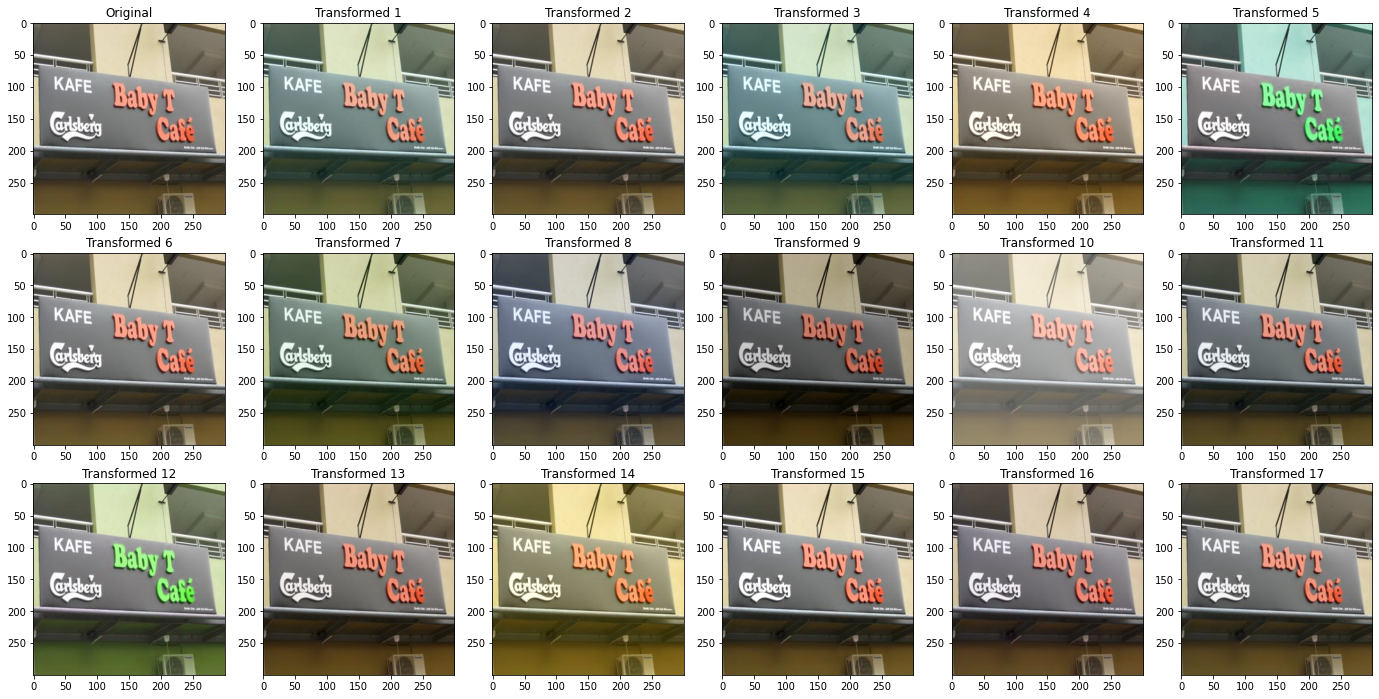

In [ ]:
# what we've got

fig, axs = plt.subplots(NROWS, NCOLS, figsize=FIGSIZE)
axs[0, 0].imshow(image)
axs[0, 0].set_title('Original')
for i in range(1, 18):
  col = i % NCOLS
  row = i // NCOLS
  image_transformed = color_transforms(image=image)['image']
  axs[row, col].imshow(image_transformed)
  axs[row, col].set_title(f'Transformed {i}')
plt.show()

##### Testing augmentations: adding noise

Usually this type of augmentation is crucial because in real life you can face with planty defects of the images.

But again, be careful with parameters, because too much noise can become a cirious obstacle for the model.

In [ ]:
noise_transforms = A.OneOf([
    A.GaussNoise(p=1., mean=0, var_limit=(20.55, 500.75), per_channel=False),
    A.GaussNoise(p=1., mean=0, var_limit=(20.55, 500.75), per_channel=True),
    A.GaussNoise(p=1., mean=0, var_limit=(100., 200.)),
    A.ISONoise(p=1., color_shift=(0.1, 0.25), intensity=(0.6, 1.))
], p=1.)

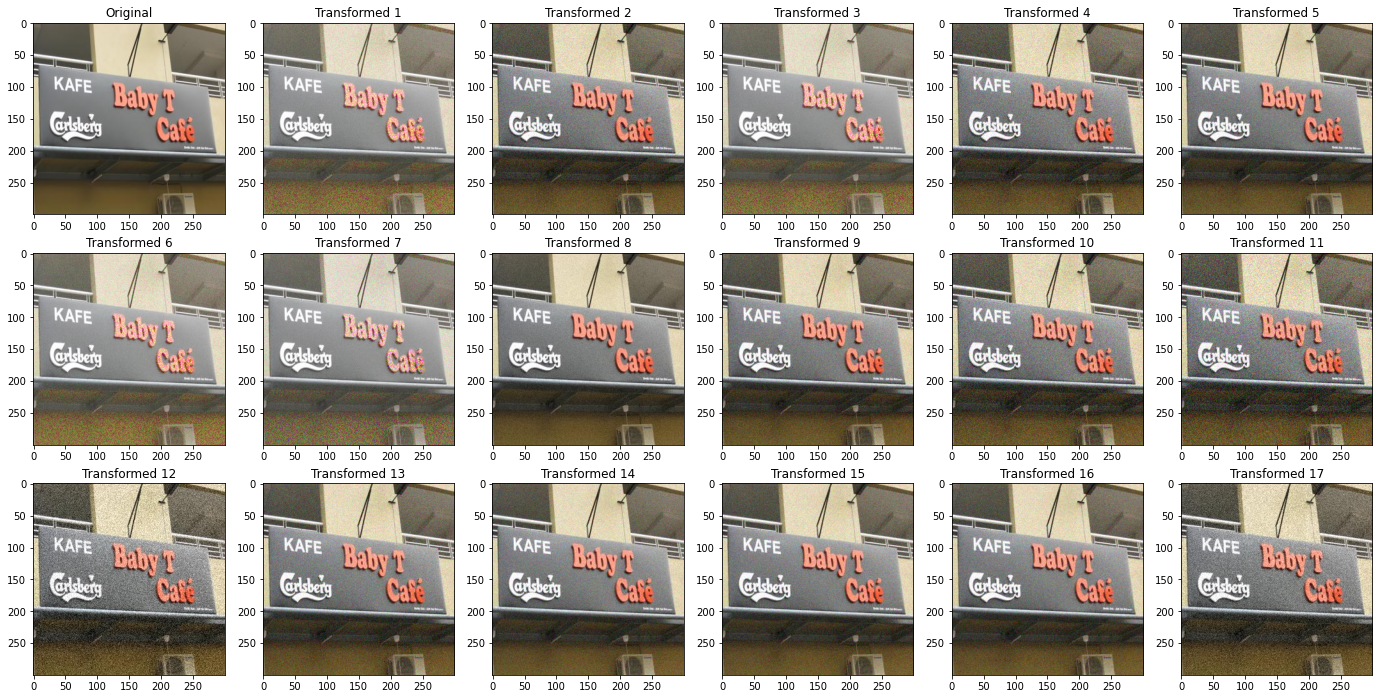

In [ ]:
# what we've got

fig, axs = plt.subplots(NROWS, NCOLS, figsize=FIGSIZE)
axs[0, 0].imshow(image)
axs[0, 0].set_title('Original')
for i in range(1, 18):
  col = i % NCOLS
  row = i // NCOLS
  image_transformed = noise_transforms(image=image)['image']
  axs[row, col].imshow(image_transformed)
  axs[row, col].set_title(f'Transformed {i}')
plt.show()

##### Testing augmentations: change perspective

This type of augmentation helps with the problem, we've faced above, when text is mainly located closer to the image center. There also can be a situation when the street view includes a billboard turn at some angle.

Please, pay attention that it's useless to set parameters related to angles with values more than 45 degrees because it can make the text unreadable.

In [ ]:
geometric_transforms = A.Compose([
    A.RandomRotate90(p=0.2),
    A.ShiftScaleRotate(
        shift_limit=(-0.25, 0.25),
        scale_limit=(-0.2, 1.5),
        interpolation=1,
        rotate_limit=45,
        border_mode=cv2.BORDER_CONSTANT,
        value=0,
        p=0.5
    ),
    A.Perspective(p=0.3, scale=(0.01, 0.15)),
])

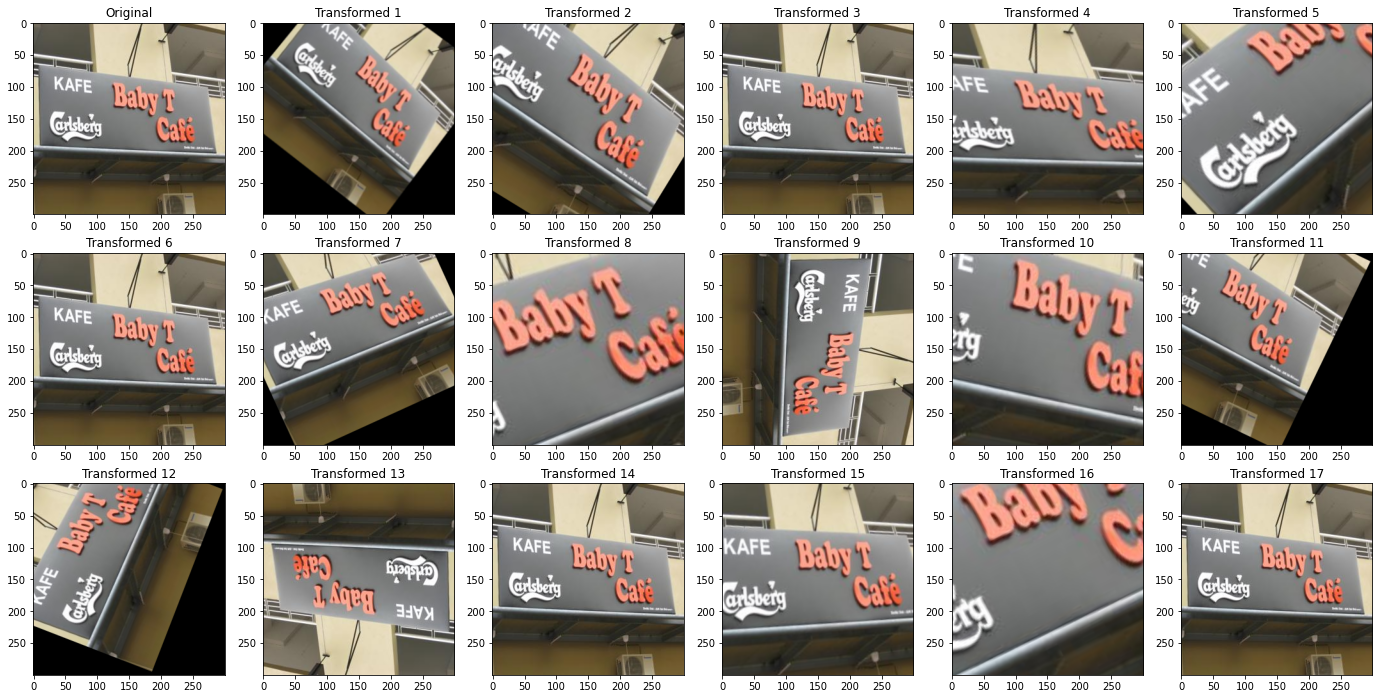

In [ ]:
# what we've got

fig, axs = plt.subplots(NROWS, NCOLS, figsize=FIGSIZE)
axs[0, 0].imshow(image)
axs[0, 0].set_title('Original')
for i in range(1, 18):
  col = i % NCOLS
  row = i // NCOLS
  image_transformed = geometric_transforms(image=image)['image']
  axs[row, col].imshow(image_transformed)
  axs[row, col].set_title(f'Transformed {i}')
plt.show()

##### Join the augmentations

In [ ]:
train_transform = A.Compose([
    size_transform,

    A.OneOf([
        # changing colors
        A.RandomBrightnessContrast(p=1., brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True),
        A.RGBShift(p=1., r_shift_limit=20, g_shift_limit=20, b_shift_limit=20),
        A.ChannelShuffle(p=0.3),
    ], p=0.3),
    A.InvertImg(p=0.1),
    A.HueSaturationValue(p=0.2, hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20),
    A.OneOf([
        # adding noise
        A.GaussNoise(p=1., mean=0, var_limit=(20.55, 500.75), per_channel=False),
        A.GaussNoise(p=1., mean=0, var_limit=(20.55, 500.75), per_channel=True),
        A.GaussNoise(p=1., mean=0, var_limit=(100., 200.)),
        A.ISONoise(p=1., color_shift=(0.1, 0.25), intensity=(0.6, 1.))
    ], p=0.4),
    A.Compose([
        # changing perspective
        A.RandomRotate90(p=0.2),
        A.ShiftScaleRotate(
            shift_limit=(-0.5, 0.5),
            scale_limit=(-0.2, 1.5),
            interpolation=1,
            rotate_limit=45,
            border_mode=cv2.BORDER_CONSTANT,
            value=0,
            p=0.5
        ),
        A.Perspective(p=0.3, scale=(0.01, 0.15)),
    ], p=0.5),
    A.ToGray(p=0.3),
])

Combining the methods we can get a huge variaty of images from a few of them.

In [ ]:
image = cv2.imread(base_folder+'examples/example_itw.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_auged_ref = cv2.imread(base_folder+'examples/example_itw_auged.jpeg')
image_auged_ref = cv2.cvtColor(image_auged_ref, cv2.COLOR_BGR2RGB)

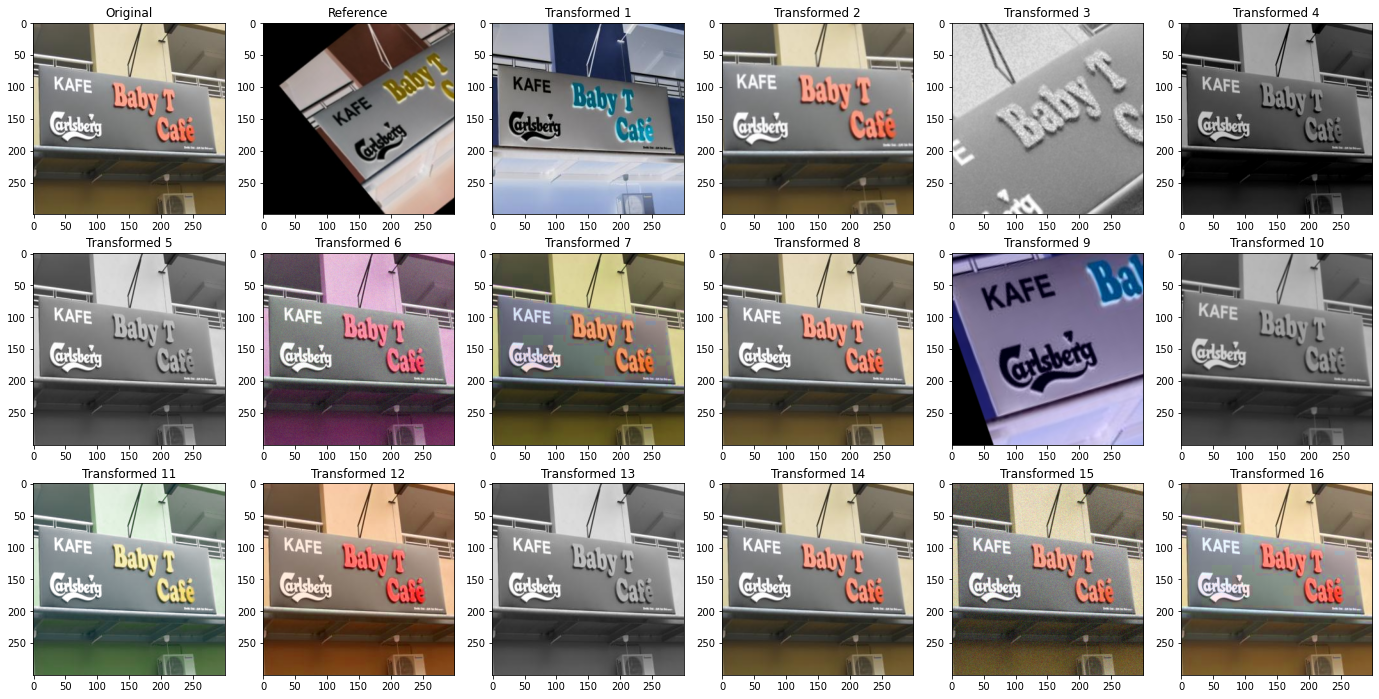

In [ ]:
fig, axs = plt.subplots(NROWS, NCOLS, figsize=FIGSIZE)
axs[0, 0].imshow(image)
axs[0, 0].set_title('Original')
axs[0, 1].imshow(image_auged_ref)
axs[0, 1].set_title('Reference')
for i in range(2, 18):
  col = i % NCOLS
  row = i // NCOLS
  # здесь используем train_transform[1:] для того, чтобы все картинки остались одного размера
  image_transformed = A.Compose(train_transform[1:])(image=image)['image']
  axs[row, col].imshow(image_transformed)
  axs[row, col].set_title(f'Transformed {i-1}')
plt.show()

In [ ]:
# postprocessing

from albumentations.pytorch import ToTensorV2

val_transform = size_transform
test_transform = size_transform

post_transform = A.Compose([
    A.Normalize(
        mean=[0, 0, 0],
        std=[1, 1, 1],
        max_pixel_value=255.,
        p=1.,
    ),
    ToTensorV2(p=1.)
])

### Turning segmentation into bounding boxes

We are solving the text detection task as a segmentation task, that's why the result of the model is segmentation maps. In order to transform the maps into bounding boxes (highlight some space with text) we need to use postprocessing. It chooses four points around a mask and represents it as a rectangle.

In [ ]:
from utils import Postprocessor

postprocessor = Postprocessor(
    unclip_ratio=1.5,
    binarization_threshold=0.3,
    confidence_threshold=0.7,
    min_area=1,
    max_number=1000
)

In [ ]:
idx = np.random.choice(len(dataset))
raw_image, image, shrink_map, shrink_mask, threshold_map, threshold_mask, gt_polygon = dataset[idx]
h, w, c = raw_image.shape
shrink_map= np.expand_dims(np.expand_dims(shrink_map, axis=0), axis=0)
map_polygons, _ = postprocessor(w, h, shrink_map, return_polygon=False)

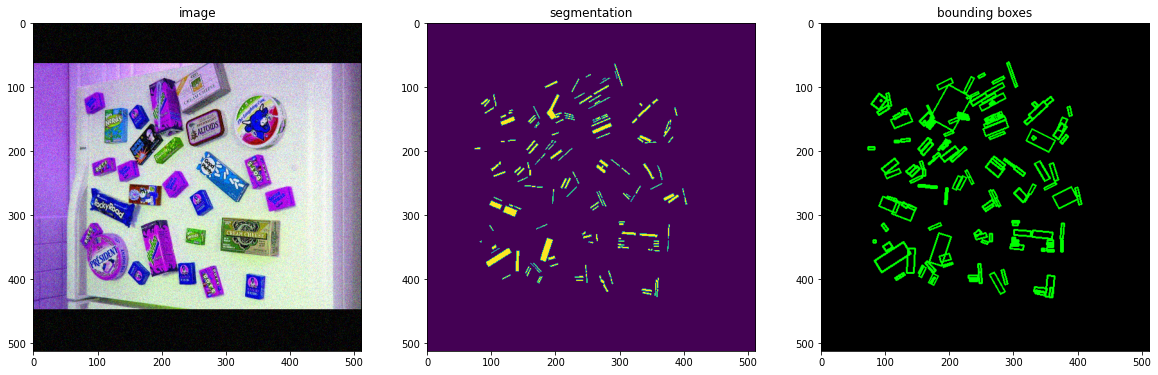

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))

ax = ax.ravel()

ax[0].set_title('image')
ax[0].imshow(raw_image)

ax[1].set_title('segmentation')
ax[1].imshow(shrink_map[0][0])

ax[2].set_title('bounding boxes')
ax[2].imshow(DrawMore.draw_contours(np.zeros_like(raw_image), map_polygons[0], thickness=2))

plt.show()

### DataLoaders' preparing

In [ ]:
import os

from torch.utils.data import DataLoader

from utils import collate, worker_init_fn

num_workers = os.cpu_count()  # number of available CPUs
batch_size = 26

train_ds = DBDataset(
    adapters=train_adapters,
    transforms=train_transform,
    post_transforms=post_transform,
    size=10000  # each epoch deals with this number of images on a training step

)
val_ds = DBDataset(
    adapters=val_adapters,
    transforms=val_transform,
    post_transforms=post_transform,
    size=4000  # each epoch deals with this number of images on a validation step
)

train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    num_workers=num_workers,
    collate_fn=collate,
    worker_init_fn=worker_init_fn,
    pin_memory=True,
    shuffle=True,
    drop_last=False
)

val_dl = DataLoader(
    val_ds,
    batch_size=batch_size,
    num_workers=num_workers,
    collate_fn=collate,
    worker_init_fn=worker_init_fn,
    pin_memory=True,
    shuffle=False,
    drop_last=False
)

# Model

We've finished with data preparation, and are ready for training a model. It should get an image as an input and return segmentation maps related to a text.

We're using a DB model ([source](https://arxiv.org/abs/1911.08947)) that has a "body" (or "encoder") and a "head" (or "decoder"). In the image below you can see the architecture of the model. Its left part (before "CON-CAT") is the "body" (we'll take it pretrained), but the "head" we'll partly realize in code.


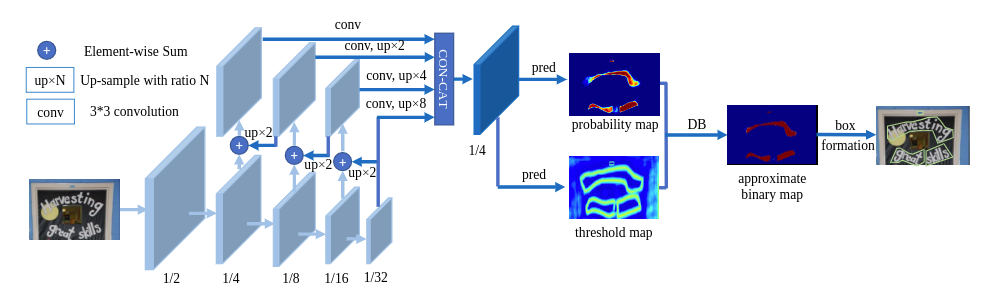

Taking a pretrained model is a good practice that helps to get higher quality metrics in comparison with training the whole model from scratch. It also leads to decreasing time that is required for training.

In comparison with other segmentation models, the chosen DB model returns adjusted edges of words (threshold map) along with a standard probability map. It allows the transformation of a probability map into a binarized images with the help of a step function (it's a function that combines probability maps and threshold maps in order to get binary masks).

### Step function for the DB model

Formula for the Step Function (from the source mentioned above):

$$\hat{B}_{i, j} = \frac{1}{1+e^{-k(P_{i,j}-T_{i,j})}}$$

where

$\hat{B}_{i, j}$ is dinamicly binarized prediction,

$P_{i,j}$ is a probability map,

$T_{i,j}$ is a threshold map,

$k$ is a coefficient which equals 50 in the article.

In [ ]:
import torch

def step_function(p: torch.Tensor, t: torch.Tensor, k: int = 50) -> torch.Tensor:
    return torch.reciprocal(1 + torch.exp(-k * (p - t)))

Let's check the function on real probability maps and threshold maps, which we can extract from an image. We also would like them with correct values of `step_function`, extracted from the image as well:

In [ ]:
prob_map = cv2.imread(base_folder + 'examples/prob_map.png', cv2.IMREAD_GRAYSCALE)
threshold_map = cv2.imread(base_folder + 'examples/threshold_map.png', cv2.IMREAD_GRAYSCALE)
true_after_step_function = cv2.imread(base_folder + 'examples/step_function.png', cv2.IMREAD_GRAYSCALE)

after_step_function = step_function(torch.from_numpy(prob_map/255), torch.from_numpy(threshold_map/255), k=50).numpy() * 255
assert np.allclose(true_after_step_function, after_step_function.astype(int)), msg

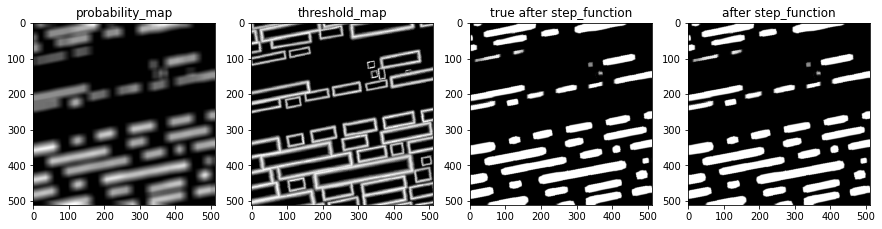

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

ax1.imshow(prob_map, cmap='gray')
ax1.set_title('probability_map')

ax2.imshow(threshold_map, cmap='gray')
ax2.set_title('threshold_map')

ax3.imshow(true_after_step_function, cmap='gray')
ax3.set_title('true after step_function')

ax4.imshow(after_step_function, cmap='gray')
ax4.set_title('after step_function')

plt.show()

It's also interesting to play with different values of $k$ parameter:

In [ ]:
from ipywidgets import interact, IntSlider

def wrapper(k=50):
  plt.figure(figsize=(6, 6))
  plt.imshow(step_function(torch.from_numpy(prob_map/255), torch.from_numpy(threshold_map/255), k), cmap='gray')

interact(wrapper, k=IntSlider(min=1, max=50, step=1, value=10));

interactive(children=(IntSlider(value=10, description='k', max=50, min=1), Output()), _dom_classes=('widget-in…

### `DBHead` coding

In [ ]:
from torch import nn

class DBHead(nn.Module):
    def __init__(self, in_channels: int, k: int = 50):
        """
        Class of DB head from the article https://arxiv.org/abs/1911.08947.
        """
        super().__init__()
        self.k = k
        self.binarize = self._init(in_channels)
        self.thresh = self._init(in_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        shrink_maps = self.binarize(x)
        threshold_maps = self.thresh(x)
        binary_maps = self.step_function(shrink_maps, threshold_maps, self.k)
        y = torch.cat((shrink_maps, threshold_maps, binary_maps), dim=1)
        return y

    def _init(
        self,
        inner_channels: int,
    ) -> nn.Module:
        return nn.Sequential(
            nn.Conv2d(inner_channels, inner_channels//4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(inner_channels//4),
            nn.ReLU(),
            nn.ConvTranspose2d(inner_channels//4, inner_channels//4, kernel_size=(2, 2), stride=(2, 2), bias=False),
            nn.BatchNorm2d(inner_channels//4),
            nn.ReLU(),
            nn.ConvTranspose2d(inner_channels//4, 1, kernel_size=(2, 2), stride=(2, 2)),
            nn.Sigmoid()
        )

    def step_function(self, p: torch.Tensor, t: torch.Tensor, k: int = 50) -> torch.Tensor:
        return torch.reciprocal(1 + torch.exp(-k * (p - t)))

### Combine the model's parts

In [ ]:
import segmentation_models_pytorch as smp
import torch.nn.functional as F

class DB(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = smp.FPN(
            encoder_name='timm-regnetx_016'
        )  # FPN из smp
        self.body.segmentation_head = torch.nn.Identity()
        self.head = DBHead(in_channels=128, k=50)  # DBHead

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _, _, H, W = x.size()
        x = self.body(x)
        x = self.head(x)
        x = F.interpolate(x, size=(H, W), mode='bilinear', align_corners=True)
        return x

# Metrics and the loss function

This section is about comparing predictions and ground truth values.

We're going to use combination of several functions:
* `BalanceCrossEntropyLoss`
* `MaskL1Loss`
* `DiceLoss`

We'll use `Precision`, `Recall` and `F-Score` as metrics calculated based on `IoU`. It means that in case of `IoU=0.05` we'll calculate `Precision` only for those pairs of polygons (predicted and true) which have `IoU > 0.05`.

In [ ]:
from utils import BaseEvaluator
from shapely.geometry import Polygon

class Evaluator(BaseEvaluator):
    @staticmethod
    def get_iou(p1: Polygon, p2: Polygon) -> float:
        return p1.intersection(p2).area / p1.union(p2).area

# Training

## Pytorch Lightning Module

In [ ]:
import pytorch_lightning as pl

from typing import Any, Tuple, List
from utils import DBLoss
from utils import log_losses_and_metrics, log_images

from torch import optim

class DBRunner(pl.LightningModule):
    def __init__(self):
        """
        Main class for training the DB model.
        """
        super(DBRunner, self).__init__()

        self.model = DB()

        self.evaluator = Evaluator() # metrics' calculation
        self.postprocessor = Postprocessor(
            unclip_ratio=1.5,
            binarization_threshold=0.3,
            confidence_threshold=0.7,
            min_area=1,
            max_number=1000
        )

        self.loss = DBLoss(
            alpha=1,
            beta=10,
            ohem_ratio=3,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def training_step(self, batch: Any, batch_idx: int) -> Any:
        raw_images, images, shrink_maps, shrink_masks, threshold_maps, threshold_masks, gt_polygons = batch
        current_batch_size = len(raw_images)
        preds = self.forward(images)

        losses = self.loss(preds, {
            'shrink_map': shrink_maps,
            'shrink_mask': shrink_masks,
            'threshold_map': threshold_maps,
            'threshold_mask': threshold_masks,
        })

        log_losses_and_metrics(self.log, losses, metrics=None, current_batch_size=current_batch_size, mode='train')

        log_images_every_n_epoch = 5

        if self.current_epoch % log_images_every_n_epoch == 0 and batch_idx == 0:
            h, w, c = raw_images[0].shape

            # preparation to visualization
            shrink_maps = DrawMore.to_numpy(shrink_maps, unsqueeze=True)
            threshold_maps = DrawMore.to_numpy(threshold_maps, unsqueeze=True)
            pred_shrink_maps = DrawMore.to_numpy(preds[:, [0], :, :])
            pred_threshold_maps = DrawMore.to_numpy(preds[:, [1], :, :])
            pred_bin_maps = DrawMore.to_numpy(preds[:, [2], :, :])

            train_gt_polygons, _ = self.postprocessor(w, h, shrink_maps, return_polygon=False)
            train_polygons_after_step, _ = self.postprocessor(w, h, pred_bin_maps, return_polygon=False)
            metrics_after_step = self.evaluator(train_gt_polygons, train_polygons_after_step)

            log_images(
                self.trainer.logger,
                raw_images,
                shrink_maps,
                threshold_maps,
                pred_bin_maps,
                pred_shrink_maps,
                pred_threshold_maps,
                train_gt_polygons,
                train_polygons_after_step,
                metrics_after_step,
                mode='train',
                log_max=4
            )

        return losses["loss"]

    def validation_step(self, batch: Any, batch_idx: int) -> Any:
        raw_images, images, shrink_maps, shrink_masks, threshold_maps, threshold_masks, gt_polygons = batch
        current_batch_size = len(raw_images)
        preds = self.forward(images)

        losses = self.loss(preds, {
            'shrink_map': shrink_maps,
            'shrink_mask': shrink_masks,
            'threshold_map': threshold_maps,
            'threshold_mask': threshold_masks,
        })

        h, w, c = raw_images[0].shape

        shrink_maps = DrawMore.to_numpy(shrink_maps, unsqueeze=True)
        pred_bin_maps = DrawMore.to_numpy(preds[:, [2], :, :])

        val_gt_polygons, _ = self.postprocessor(w, h, shrink_maps, return_polygon=False)
        val_polygons_after_step, _ = self.postprocessor(w, h, pred_bin_maps, return_polygon=False)
        metrics_after_step = self.evaluator(val_gt_polygons, val_polygons_after_step)

        log_losses_and_metrics(self.log, losses, metrics_after_step, current_batch_size=current_batch_size, mode='val')

        log_images_every_n_epoch = 5

        if self.current_epoch % log_images_every_n_epoch == 0 and batch_idx == 0:
            threshold_maps = DrawMore.to_numpy(threshold_maps, unsqueeze=True)
            pred_shrink_maps = DrawMore.to_numpy(preds[:, [0], :, :])
            pred_threshold_maps = DrawMore.to_numpy(preds[:, [1], :, :])

            log_images(
                self.trainer.logger,
                raw_images,
                shrink_maps,
                threshold_maps,
                pred_bin_maps,
                pred_shrink_maps,
                pred_threshold_maps,
                val_gt_polygons,
                val_polygons_after_step,
                metrics_after_step,
                mode='val'
            )

    def test_step(self, batch: Any, batch_idx: int) -> Any:
        """
        Testing step is the same as a validation step.
        """
        self.validation_step(batch, batch_idx)

    def configure_optimizers(self) -> Tuple[List[Any], List[Any]]:
        """
        Method for optimizers' and schedulers' (for learning rate (LR)) configuration.

        Returns:
            list of optimizers; list of schedulers
        """
        optimizer = optim.AdamW(
            self.parameters(), lr=5.0e-4, betas=(0.9, 0.999), weight_decay=0.0005)
        lr_scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer=optimizer,
            base_lr=0.0001,
            max_lr=0.0075,
            step_size_up=235,
            step_size_down=235 * 4,
            mode="triangular",
            cycle_momentum=False,
        )
        scheduler = {
            "scheduler": lr_scheduler,
            "interval": "step",
            "frequency": 1, # every batch (for some losses it can be crucial to run it once per an epoch)
            "monitor": "val_losses/val_loss_epoch",
        }
        print(lr_scheduler)
        print(optimizer)
        return [optimizer], [scheduler]

## Logging

### Save weights

In [ ]:
from datetime import datetime
import os

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

model = DBRunner()

version = datetime.now().strftime("%Y%m%dT%H%M%S")

lr_logger = LearningRateMonitor()

logs_dir = "/content/drive/MyDrive/tmp/logs"
project_name = "sber-td-course" # will be mentioned at Wandb
exp_name = f"first_hw_{version}"

cfg_save_dir = os.path.join(logs_dir, project_name, exp_name)
checkpoint_callback = ModelCheckpoint(
    dirpath=cfg_save_dir,
    mode="min",
    monitor="val_losses/val_loss_epoch",
    save_top_k=1,
    verbose=True,
    save_last=True
)

### Saving metrics

For logging of experiments we're using Weights and Biases.

In [ ]:
os.environ['WANDB_API_KEY'] = open('/content/drive/MyDrive/ssh/wandbkey.txt').read()
logger = WandbLogger(
    save_dir=logs_dir,
    project=project_name,
    name=exp_name,
)

In [ ]:
# wandb.finish()

## Start training

In [ ]:
trainer = Trainer(
    callbacks=[checkpoint_callback, lr_logger],
    logger=logger,
    gpus=[0],
    min_epochs=1,
    max_epochs=20,
    gradient_clip_val=0.5,
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | model | DB     | 10.4 M
1 | loss  | DBLoss | 0     
---------------------------------
10.4 M    Trainable params
0         Non-trainable params
10.4 M    Total params
41.535    Total estimated model params size (MB)


AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0.0005
)


Sanity Checking: 0it [00:00, ?it/s]

/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/points2polygon.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  pol.idx = idx
/content/drive/MyDrive/github/IntelligentDocumentProcessing/Resources/a_Text_Detection/utils/base_evaluator.py:66: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  s = STRtree(gt_polygons)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 319: 'val_losses/val_loss_epoch' reached 1.81312 (best 1.81312), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/first_hw_20221105T215522/epoch=0-step=319.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 638: 'val_losses/val_loss_epoch' reached 1.54011 (best 1.54011), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/first_hw_20221105T215522/epoch=1-step=638.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 957: 'val_losses/val_loss_epoch' reached 1.44434 (best 1.44434), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/first_hw_20221105T215522/epoch=2-step=957.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1276: 'val_losses/val_loss_epoch' reached 1.42943 (best 1.42943), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/first_hw_20221105T215522/epoch=3-step=1276.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1595: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1914: 'val_losses/val_loss_epoch' reached 1.39783 (best 1.39783), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/first_hw_20221105T215522/epoch=5-step=1914.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 2233: 'val_losses/val_loss_epoch' reached 1.31045 (best 1.31045), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/first_hw_20221105T215522/epoch=6-step=2233.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 2552: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 2871: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 3190: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 3509: 'val_losses/val_loss_epoch' reached 1.25977 (best 1.25977), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/first_hw_20221105T215522/epoch=10-step=3509.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 3828: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 4147: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 4466: 'val_losses/val_loss_epoch' reached 1.25655 (best 1.25655), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/first_hw_20221105T215522/epoch=13-step=4466.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 4785: 'val_losses/val_loss_epoch' reached 1.24919 (best 1.24919), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/first_hw_20221105T215522/epoch=14-step=4785.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 5104: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 5423: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 5742: 'val_losses/val_loss_epoch' reached 1.22746 (best 1.22746), saving model to '/content/drive/MyDrive/tmp/logs/sber-td-course/first_hw_20221105T215522/epoch=17-step=5742.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 6061: 'val_losses/val_loss_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 6380: 'val_losses/val_loss_epoch' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


## Testing

Usually, we're working with three datasets: train, validation, and test, but opensource `HierText` includes just two datasets that's why we're testing our model on the validation set.

In [ ]:
test_adapters = [
    ('hiertext', val_hiertext_adapter),
]

num_workers = os.cpu_count()
batch_size = 16

test_transform = size_transform

test_dls = []

for (adapter_name, adapter) in test_adapters:
    test_dataset = DBDataset(
        adapters=[adapter],
        transforms=test_transform,
        post_transforms=post_transform
    )
    test_dl = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        collate_fn=collate,
        worker_init_fn=worker_init_fn,
        pin_memory=True,
        shuffle=False,
        drop_last=False
    )
    test_dls.append((adapter_name, test_dl))

In [ ]:
model = DBRunner.load_from_checkpoint('/content/drive/MyDrive/tmp/logs/sber-td-course/first_hw_20221105T215522/epoch=17-step=5742.ckpt') # need to update

for (dl_name, dl) in test_dls:
    print(dl_name)
    trainer.test(model=model, dataloaders=dl)

hiertext


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                  Test metric                                   DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     val_losses/val_loss_binary_maps_epoch                   0.23729605972766876
           val_losses/val_loss_epoch                          1.23251211643219
     val_losses/val_loss_shrink_maps_epoch                   0.2935226559638977
   val_losses/val_loss_threshold_maps_epoch                  0.0701693668961525
val_metrics/val_mean_fscore_30_after_step_epoch              0.6232190332789505
val_metrics/val_mean_fscore_50_after_step_epoch              0.49038044675723813
val_metrics/val_mean_fscore_75_after_step_epoch              0.2553559269025113
 val_metrics/val_mean_fscore_after_step_epoch                0.39067710516764886
val_metrics/val_mean_precision_after_st

# Saving the best model

There are several ways to save a model. But if you use .ckpt or .pth formats then each launch of the model for inference will require to have the code of the model. This limitation can be avoided in the case of using [TorchScript](https://pytorch.org/docs/stable/jit.html). This framework helps to serialize models and run them in a line of code.

In [ ]:
from typing import Type

def jit_save(checkpoint_path: str, jit_path: str, runner_class: Type[DBRunner]) -> None:
    model = runner_class.load_from_checkpoint(checkpoint_path).model.eval()
    input_example = torch.rand(1, 3, 512, 512)
    torch.jit.save(torch.jit.trace(model, input_example), jit_path)

# Inference

In [ ]:
from typing import Union

from albumentations import BasicTransform, Compose, OneOf

def inference(
    model: nn.Module,
    image: np.ndarray,
    preprocessor: Union[BasicTransform, Compose, OneOf],
    postprocessor: Postprocessor,
    device: str = 'cpu',
) -> List[np.ndarray]:

    # image preprocessing
    image_changed = preprocessor(image=image)['image']
    image_changed = torch.Tensor(image_changed[np.newaxis,:])#.permute(0,3,1,2)
    # getting predictions
    with torch.no_grad():
        prediction = model(image_changed).to(device)
    # пpostprocessing the predictions
    pred_image = prediction.cpu().detach().numpy()
    bboxs = postprocessor(2048, 2048, pred_image, return_polygon=False)[0][0]
    res = [np.array(x) for x in bboxs]

    return res

size=512
preprocessor = A.Compose([
    test_transform,
    A.Normalize(
        mean=[0, 0, 0],
        std=[1, 1, 1],
        max_pixel_value=255.,
        p=1.,
    ),
    ToTensorV2(p=1.)
])
postprocessor = postprocessor

#### Example of how it works

In [ ]:
model = torch.jit.load('/content/drive/MyDrive/models/model_td.jit')
model.eval()

image = cv2.imread(base_folder+'examples/example4.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (2048, 2048))

bboxes = inference(model, image, preprocessor, postprocessor, 'cuda:0')  # it can be CPU as well

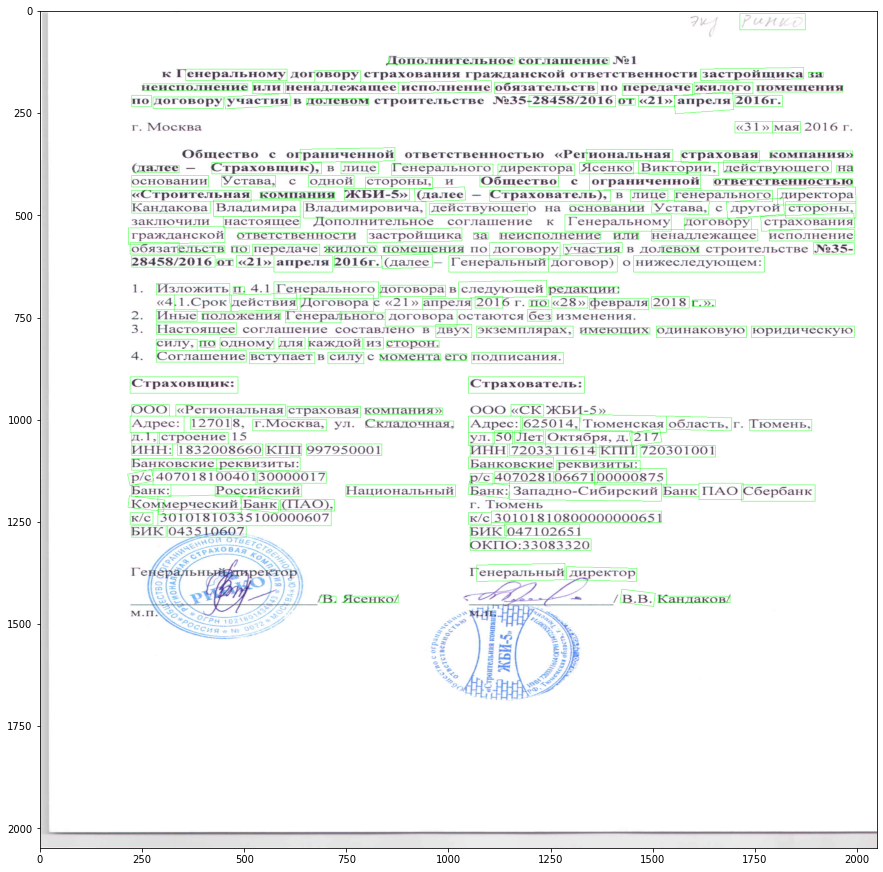

In [ ]:
plt.figure(figsize=(15,20))
plt.imshow(DrawMore.draw_contours(image, bboxes, thickness=1))
plt.show()